## Project 2 Report - Continous Control

- Author: Thiago Akio Nakamura
- Date: May 2021
- Repo: https://github.com/akionakamura/drlnd-p2

### Introduction
This document contains the report for the Project 2 of the Deep Reinforcement Learning Nano Degree from Udacity. The goal of this project is to train an reinforcement learning agent to for a continous control problem. This report explains the algorithms used, as well as the tests parameters and the obtained results. The reader is also encouraged to read through the source code, for the detailed implementations of the neural networks and the agent itself.

### The environment
The `Reach` environment consists in a dual-jointed robotic arm that needs to follow a target location. A reward of +0.1 is provided for each step that the agent's hand is in the goal location. Thus, the goal of the agent is to maintain its position at the target location for as many time steps as possible. Its observation space has 33 variables corresponding to position, rotation, velocity, and angular velocities of the arm. The action space corresponds to 4 continuous variables varying between [-1, 1], where each corresponds to torque applicable to two joints.

#### The Goal
The task is episodic, and the used environment provides 20 arms simultaneously. So in order to solve the environment, the agent must get an average score averaged over the 20 agents of +30 over 100 consecutive episodes.

In [1]:
import os
import time
from collections import deque
from dataclasses import asdict

from unityagents import UnityEnvironment
import mlflow
import numpy as np
import torch

from agents import MultiAgent
from experiment import RunExperiments, RunConfig

/home/akio/.pyenv/versions/3.6.12/envs/drlnd-p2/lib/python3.6/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
# Global constants for the project.
# Number of episodes to train all agents.
NUM_EPISODES = 500

# Consecutive runs to average the scores.
RESULT_WINDOW = 100

# Minimum average score over the window to complete the project.
MIN_AVERAGE_SCORE = 30

In [3]:
experiments_to_run = RunExperiments(
    learn_steps=[2],
    sync_steps=[16],
    batch_sizes=[32],
    gammas=[0.99],
    epsilon_decays=[0.99]
)
NUM_EXPERIMENTS = 8

In [4]:
env = UnityEnvironment(file_name='./Reacher_Linux/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### Learning Algorithms

The environment has both state and actions with continuous values, therefore we cannot use the traditional Q-Learning algorithms for learning. Looking specifically at algorithms designed to work with continuous actions, we are going to train an agent using Deep Deterministic Policy Gradient (DDPG) algorithm [1].

#### DDPG

The Deep Deterministic Policy Gradient (DDPG) that directly learns a policy, i.e., given a state, its output is directly the action to be taken (actor). Concurrently, an DDPG a Q-function to estimate the future return (critic). Therefore, the DDPG method fits within the Actor-Critic family of algorithms. To increase stability, both networks (actor and critic) have mirroring network, usually called target, that is always kept off-sync with the main network weights. In [this link](https://spinningup.openai.com/en/latest/algorithms/ddpg.html) you can find a fine introduction to the algorithm.

In [7]:
def train(num_episodes, env, agent):
    all_scores = []
    score_window = deque(maxlen=RESULT_WINDOW)
    solved = False
    best_mean_score = 0
    
    for episode_i in range(num_episodes):
    
        env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)

        while True:
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished

            agent.step(states, actions, rewards, next_states, dones)

            states = next_states                               # roll over states to next time step
            scores += env_info.rewards                         # update the score (for each agent)
            
            if np.any(dones):                                  # exit loop if episode finished
                break
        
        agent.episode_finished()
        avg_score = np.mean(scores)
        score_window.append(avg_score)
        all_scores.append(avg_score)
        
        current_mean = np.mean(score_window)
        if current_mean >= MIN_AVERAGE_SCORE:
            solved = True
        
        if current_mean > best_mean_score:
            best_mean_score = current_mean
        mlflow.log_metric("current_mean", current_mean, step=episode_i)
        print(f"\r  Average score on episode {episode_i}: {current_mean}", end="")
        
    return all_scores, solved, best_mean_score, current_mean

#### Training

This class of Reinforcement Learning algorithms can be quite unstable and very sensitive to hyperparameters. Here, we designed an experiment to have several runs with different hyperparameters, and used [MLFlow](https://mlflow.org/) to track the results. The main hyperparameters tweaked were:

1. `learn_step`: how many steps to take into the environment between each learning cycle. Values: `[1, 2, 4]`
2. `sync_step`: how many steps to take into the environment between each synchronization between the weights of the local and target networks (both actor and critic). Values: `[8, 16, 32]`
3. `batch_size`: how many samples to get from the replay buffer at each learning step. Values: `[16, 32, 64]`
4. `gamma`: the discount factor. Values: `[0.95, 0.99]`
5. `epsilon_decays`: how fast the added noise in the action decreases. Values: `[0.98, 0.99]`

We ran a random search across the hypeparameter space, and the first set of hyperparameters the solved the environment were the following, and the ones used in this report:

1. `learn_step=2`
2. `sync_step=16`
3. `batch_size=32`
4. `gamma=0.99`
5. `epsilon_decays=0.99`

### Network Architecture
#### Actor
The actor network simply gets the state representation as input, and outputs directly the action to be takes (in continuous space), i.e., it represents the policy. The chosen architecture is pretty straight forward, with three fully-connected layers in a row. The hiddens layers have 128 neurons and ReLU activation function, whist the last layer has 4 units (action size) with `tanh` activation layer, leading to number between `[-1, 1]`. Follows the image representing this architecture.
<img src="actor.png">

#### Critic
The Critic network has a role to approximate the Q-function, and therefore receives as input both the state and the action. Its output is a single number representing the projected total return. The state value are first passed through a single fully-connected layer, which result is concatenated to the action tensor. From there on, with follow two more fully-connected layers. All hidden layers have 128 units, except the last, which has 64. Leaky ReLU was used as the activation function, but the output layer has a linear activation, so its value can extend to the real numbers set. Follows the image representing this architecture.
<img src="critic.png">

In [8]:
%%time

experiment_scores = {}
mlflow.set_experiment("reacher-ddpg")
for i, config in enumerate(experiments_to_run.get_configs(NUM_EXPERIMENTS)):
    with mlflow.start_run(run_name=f"Config {i}"):
        start_time = time.time()
        config = experiments_to_run.get_random()
        print(f"Running experiment {i} with config: {config}")
        mlflow.log_params(asdict(config))
        
        agent = MultiAgent(
            num_agents,
            state_size,
            action_size,
            gamma=config.gamma,
            learn_step=config.learn_step,
            sync_step=config.sync_step,
            epsilon_decay=config.epsilon_decay,
            batch_size=config.batch_size
        )

        scores, solved, best_mean_score, last_mean_score = train(NUM_EPISODES, env, agent)
        experiment_scores[config] = scores
        end_time = time.time()
        elapsed = end_time - start_time
        print(f"  Ran experiment in {elapsed} seconds.")
        print(f"  Best mean score of {best_mean_score}.")
        print(f"  Latest mean score of {last_mean_score}.")
        mlflow.log_metric("best_mean_score", best_mean_score)
        mlflow.log_metric("last_mean_score", last_mean_score)

        if solved:
            print("  Solved.")
            os.makedirs(f"./models/{i}/", exist_ok=True)
            torch.save(agent.actor_local.state_dict(), f"./models/{i}/actor.pth")
            torch.save(agent.critic_local.state_dict(), f"./models/{i}/critic.pth")
            break

Running experiment 0 with config: RunConfig(learn_step=2, sync_step=16, batch_size=32, gamma=0.99, epsilon_decay=0.99)
  Average score on episode 499: 37.71757915694639  Ran experiment in 98824.77815699577 seconds.
  Best mean score of 37.859349153777586.
  Latest mean score of 37.71757915694639.
  Solved.
CPU times: user 1d 9h 5min 39s, sys: 5min 30s, total: 1d 9h 11min 9s
Wall time: 1d 3h 27min 4s


### Results


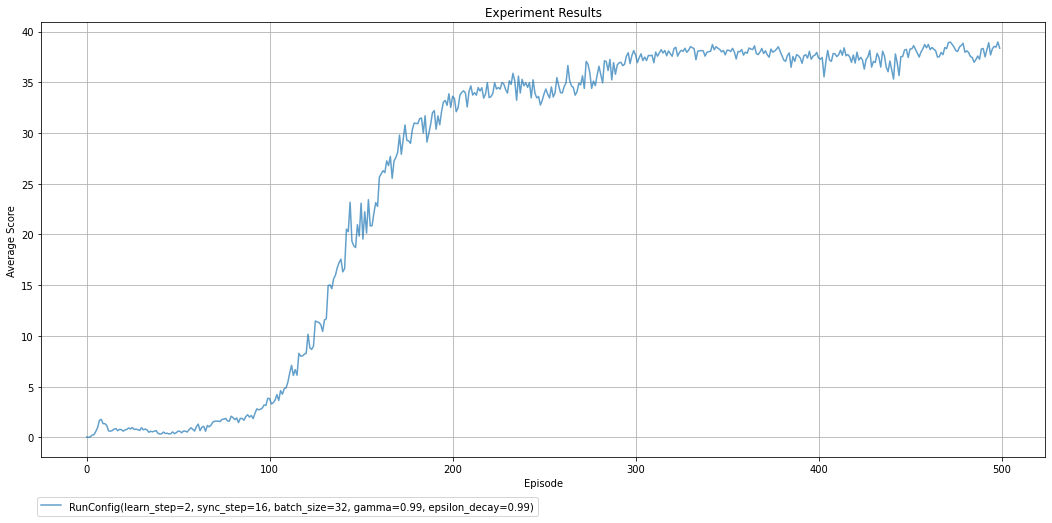

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 8))
for c, scores in experiment_scores.items():
    plt.plot(scores, label=c, alpha=0.7)
    
plt.title("Experiment Results")
plt.ylabel("Average Score")
plt.xlabel("Episode")
plt.legend(bbox_to_anchor=(0.5, -0.08))
plt.grid()
plt.show()

Next follow a single block of code the load the trained agent and see one episode in the environment.

In [11]:
agent = MultiAgent(
    num_agents,
    state_size,
    action_size,
    epsilon_start=0.0,
    min_epsilon=0.0)
agent.actor_local.load_state_dict(torch.load(f"./models/{i}/actor.pth"))
agent.actor_target.load_state_dict(torch.load(f"./models/{i}/actor.pth"))
agent.critic_local.load_state_dict(torch.load(f"./models/{i}/critic.pth"))
agent.critic_target.load_state_dict(torch.load(f"./models/{i}/critic.pth"))

done = False
env_info = env.reset(train_mode=False)[brain_name]
states = env_info.vector_observations
final_score = 0

while not done:
    actions = agent.act(states)
    env_info = env.step(actions)[brain_name]
    next_states = env_info.vector_observations
    rewards = env_info.rewards
    dones = env_info.local_done

    states = next_states
    final_score += np.mean(env_info.rewards)

    if np.any(dones):
        done = True

print(f"Final score: {final_score}")

Final score: 37.995499150734716


When finished, you can close the environment.

In [ ]:
env.close()

### Conclusion

We trained a DDPG agent to solve the Reacher environment, with 20 arms. We ran several experiments to find a good hyperparameters set, and finally got an agent the surpassed the goal and solved the environment, with an peak average score of 37.86.

### Future Work

For future works we could try to accelerate the training and execution of the algorithm, which was quite slow. For example, the winning agent took 27hrs to train for 500 epochs (on CPU), the running of several experiments was quite painful. Furthermore, we could try to implement other algorithms, such as PPO [2], A3C [3], and D4PG [4].

### References

1. [Continuous control with deep reinforcement learning](https://arxiv.org/abs/1509.02971)
2. [Proximal Policy Optimization Algorithms](https://arxiv.org/pdf/1707.06347.pdf)
3. [Asynchronous Methods for Deep Reinforcement Learning](https://arxiv.org/pdf/1602.01783.pdf)
4. [Distributed Distributional Deterministic Policy Gradients](https://openreview.net/pdf?id=SyZipzbCb)